In [165]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.impute import KNNImputer
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances

import scipy.cluster.hierarchy as shc

import itertools

from datetime import datetime
import warnings

import heapq

# Importar datos

In [166]:
df = pd.read_csv("datos_de_clientes.csv", delimiter="\t")

def set_pandas_display_options():
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 2240
    display.max_colwidth = 199
    display.width = 1000

set_pandas_display_options()

## Visualización inicial de los datos

In [167]:
print(f"Cantidad de datos: {len(df)} \n")
print(f"Columnas usadas: {df.columns} \n")
print(f"Información relevante: \n{df.describe()} \n\n")

print(f'Primeros datos de la tabla: \n{df.head(5)}\n')
print(f'Ultimos datos de la tabla: \n{df.tail(5)}')

Cantidad de datos: 2240 

Columnas usadas: Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'], dtype='object') 

Información relevante: 
                 ID   Year_Birth         Income      Kidhome     Teenhome      Recency     MntWines    MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2     Complain  Z_CostContact  Z_Revenue     Response
count   2240.000000  2240.000000    2216.000000  2240.000000  2

# Limpieza de datos

## Transformacion 1 - Eliminar constantes

z_costcontact y z_costrevenue es constante en todos los datos. Por tanto, no dan información valiosa y pueden eliminarse.

In [168]:
df = df.drop(columns=['Z_CostContact', 'Z_Revenue'])

## Transformacion 2 - Año de nacimiento

Encontrar el año mayor

In [169]:
max_age = max(df['Year_Birth'])
max_age

1996

Dado que la persona más joven tiene más de 18 años, podemos tener en cuenta que todas las campañas se enfocan a adultos.

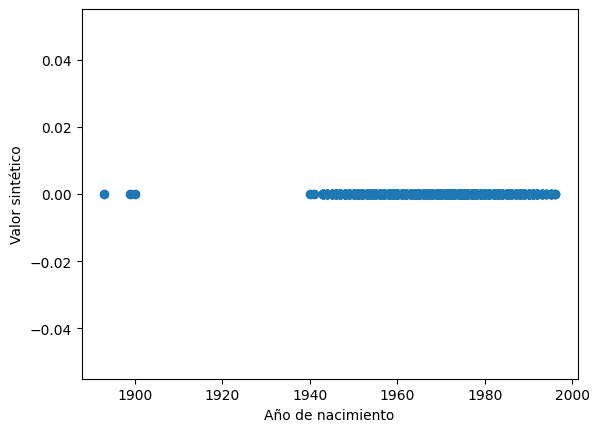

In [170]:
plt.scatter(df['Year_Birth'], np.zeros_like(df['Year_Birth']))
plt.xlabel('Año de nacimiento')
plt.ylabel('Valor sintético')
plt.show()

Como podemos ver, los años bajo 1935(aprox) son outliers. Tiene sentido debido a que son los propios usuarios los que rellenan este campo. Debido a la importancia de la columna, consideramos más apropiado dropear estos datos más que transformarlos o intentar hacerlos más uniformes.

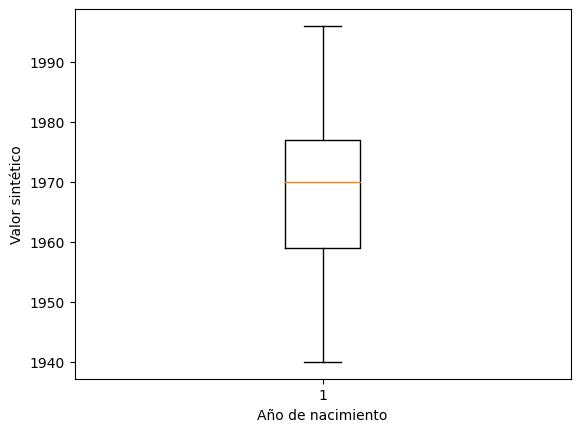

In [171]:
df = df[df.Year_Birth > 1920]

plt.boxplot(df['Year_Birth'])
plt.xlabel('Año de nacimiento')
plt.ylabel('Valor sintético')
plt.show()

Ahora tenemos una representación más uniforme sin outliers. Transformemos estos datos en edades para que sean más fácilmente legibles.

In [172]:
df['Age'] = 2020 - df['Year_Birth']
df = df.drop(columns=['Year_Birth'])

Con esto la información ha sido limpiada y es más fácil de interpretar.

## Transformacion 3 - Estatus Marital

Veamos que estados maritales hay

In [173]:
marital_values = set(df['Marital_Status'])
marital_values

{'Absurd',
 'Alone',
 'Divorced',
 'Married',
 'Single',
 'Together',
 'Widow',
 'YOLO'}

In [174]:
absurd_total = len(df[df.Marital_Status == 'Absurd'])
print(f"Num de personas con Marital Status = Absurd = {absurd_total}")

yolo_total = len(df[df.Marital_Status == 'YOLO'])
print(f"Num de personas con Marital Status = YOLO = {yolo_total}")

Num de personas con Marital Status = Absurd = 2
Num de personas con Marital Status = YOLO = 2


Absurd, Alone y YOLO no tienen sentido. Transformemos estos valores:

- Alone ---> Single
- Absurd ---> Drop
- YOLO ---> Drop

Dropeamos los ultimos clientes porque no representan ningun porcentaje significativo

In [175]:
df = df.replace('Alone', 'Single')
df = df[df.Marital_Status != 'Absurd']
df = df[df.Marital_Status != 'YOLO']

marital_values = set(df['Marital_Status'])
marital_values

{'Divorced', 'Married', 'Single', 'Together', 'Widow'}

Ahora tenemos solo los valores significativos.

In [176]:
marital_encoded = pd.get_dummies(df["Marital_Status"], prefix="Mar_status", dtype=int)
df = pd.concat([df, marital_encoded], axis=1)
df = df.drop("Marital_Status", axis=1)

Esta columna cualitativa ha sido transformada con Bernoulli. Reduzcamos esta información a dos columnas igualmente significativas, que indiquen si el usuario tiene pareja o no, que nos indican si tienen o no parejas.

In [177]:
df['Is_single'] = df['Mar_status_Single'] + df['Mar_status_Divorced'] + df['Mar_status_Widow']

df = df.drop("Mar_status_Single", axis=1)
df = df.drop("Mar_status_Divorced", axis=1)
df = df.drop("Mar_status_Widow", axis=1)
df = df.drop("Mar_status_Together", axis=1)
df = df.drop("Mar_status_Married", axis=1)

Así, reducimos esta información cualitativa a solo dos columnas codificadas cuantitativas.

## Transformacion 4 - Education

Veamos que niveles de educacion hay

In [178]:
education_values = set(df['Education'])
education_values

{'2n Cycle', 'Basic', 'Graduation', 'Master', 'PhD'}

No hay que tratar estas columnas aparte de su codificacion Bernoulli

In [179]:
education_encoded = pd.get_dummies(df["Education"], prefix="Edu", dtype=int)
df = pd.concat([df, education_encoded], axis=1)
df = df.drop("Education", axis=1)

## Transformacion 5 - Fecha de inscripcion

Debido a que no es ideal tratar datos cualitativos a la hora de graficar nuestra base de datos, transformaremos la fecha de inscripción, dada en forma de String, en una serie de columnas int que nos permitan mejor visualización de esta información.

In [180]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], dayfirst=True)

Ahora transformemos este dato en información útil midiendo la cantidad de días que han pasado desde su inscripción.

In [181]:
current = datetime(2020,1,1)
df['Days_Suscribed'] = (current - pd.to_datetime(df['Dt_Customer'])).dt.days

df = df.drop(columns=['Dt_Customer'])

## Transformacion 6 - Ingresos

Gracias al escaneo visual de la base de datos, encontramos que hay clientes que tienen el campo de Income vacío. Los llenaremos con posterior imputation, en concreto K Nearest Neighbours.

In [182]:
from sklearn.impute import KNNImputer

k = 1
imputer = KNNImputer(n_neighbors=k)

filled_df = imputer.fit_transform(df)
df = pd.DataFrame(filled_df, columns=df.columns)

Con los datos sin ningun nulo, ahora grafiquemoslos

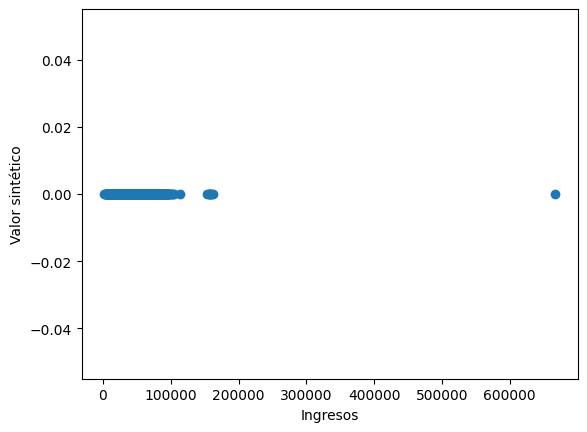

In [183]:
plt.scatter(df['Income'], np.zeros_like(df['Income']))
plt.xlabel('Ingresos')
plt.ylabel('Valor sintético')
plt.show()

Bajo el mismo tren de pensamiento del año de nacimiento, eliminaremos el outlier extremo de la derecha.

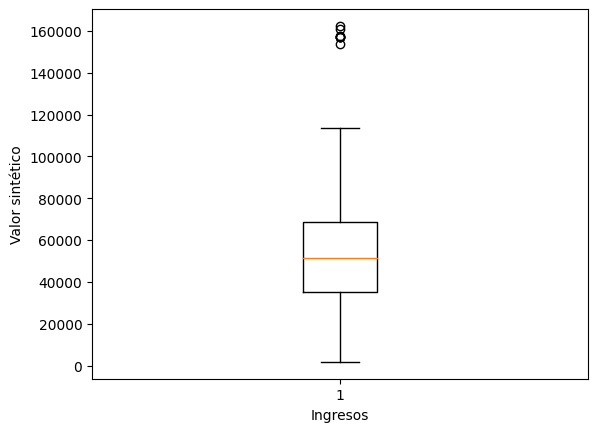

In [184]:
df = df[df.Income < 300000]

plt.boxplot(df['Income'])
plt.xlabel('Ingresos')
plt.ylabel('Valor sintético')
plt.show()

Encontremos los outliers utilizando cuartiles

In [185]:
cuartiles = np.quantile(df['Income'], [0,0.25,0.5,0.75,1])
print(f'Cuartiles: {cuartiles}')

iqr = cuartiles[3] - cuartiles[1]
lower_bound = cuartiles[1] - 1.5*iqr
upper_bound = cuartiles[3] + 1.5*iqr

outlier_range = (lower_bound, upper_bound)
print(f'Rango de datos no atipicos: {outlier_range}')

Cuartiles: [  1730.    35233.5   51277.    68468.25 162397.  ]
Rango de datos no atipicos: (-14618.625, 118320.375)


Eliminaremos todos los datos atípicos dado que no representan al resto de nuestros consumidores

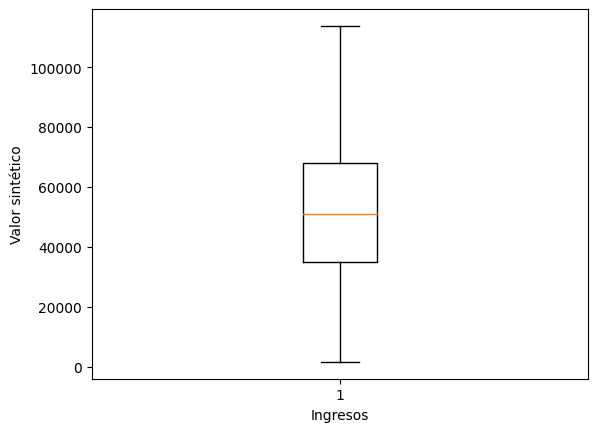

In [186]:
df = df[df.Income < outlier_range[1]]

plt.boxplot(df['Income'])
plt.xlabel('Ingresos')
plt.ylabel('Valor sintético')
plt.show()

Los datos ahora estan mucho mejor distribuidos

## Transformacion 7 - Children

Debido a que no hay una diferenciación importante entre tener adolescentes o niños en casa (al menos basados en los productos que se presentan), juntaremos ambas columnas en una única columna derivada llamada 'Children'

In [187]:
df['Children'] = df['Kidhome'] + df['Teenhome']
df = df.drop(columns=['Teenhome','Kidhome'], axis=1)

## Transformacion 8 - TotalAcceptedCmp

Para conseguir otro dato relevante, juntaremos en una sola variable todas las campañas que el usuario haya aceptado, para verificar el número total de campañas aceptadas y medir más fácilmente quienes son los más probables a aceptar nuevas campañas.

In [188]:
df['TotalAcceptedCmp'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5'] + df['Response']
df = df.drop(columns=['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Response'], axis=1)

Con esto tenemos una nueva columna con información util para decidir si un cliente podría aceptar nuevas campañas o no.

## Transformacion 9 - TotalSpent

Como último dato relevante, juntaremos en una sola variable el valor total de dinero que el cliente haya gastado para comprobar que tanto es probable que gaste en la tienda.

In [189]:
df['TotalSpent'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

Con esto tenemos una nueva columna con información util que nos indica que tanto utiliza el sistema el cliente.

## Transformacion 10 - ID

El ID no me da ninguna informacion relevante acerca del usuario, por tanto, lo eliminaremos.

In [190]:
df = df.drop(columns=['ID'])

# Datos después de ser tratados

In [191]:
print(f"Cantidad de datos: {len(df)} \n")
print(f"Columnas usadas: {len(df.columns)}, {df.columns} \n")
print(f"Información relevante: \n{df.describe()} \n\n")

print(f'Primeros datos de la tabla: \n{df.head(5)}\n')
print(f'Ultimos datos de la tabla: \n{df.tail(5)}')

Cantidad de datos: 2224 

Columnas usadas: 25, Index(['Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Complain', 'Age', 'Is_single', 'Edu_2n Cycle', 'Edu_Basic', 'Edu_Graduation', 'Edu_Master', 'Edu_PhD', 'Days_Suscribed', 'Children', 'TotalAcceptedCmp', 'TotalSpent'], dtype='object') 

Información relevante: 
              Income      Recency     MntWines    MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth     Complain         Age    Is_single  Edu_2n Cycle    Edu_Basic  Edu_Graduation   Edu_Master      Edu_PhD  Days_Suscribed     Children  TotalAcceptedCmp   TotalSpent
count    2224.000000  2224.000000  2224.000000  2224.000000      2224.000000      2224.000000       2224.000000   2224.000

# Clusterings

## Normalizacion de datos

In [192]:
column_list = df.columns

scaler = StandardScaler()
normalized_array = scaler.fit_transform(df)
df_normalized = pd.DataFrame(normalized_array, columns=column_list)

In [193]:
pca_2D = PCA(n_components=2)
pca_3D = PCA(n_components=3)

df_PCA2D = pca_2D.fit_transform(df_normalized)
df_PCA3D = pca_3D.fit_transform(df_normalized)

## Kmeans

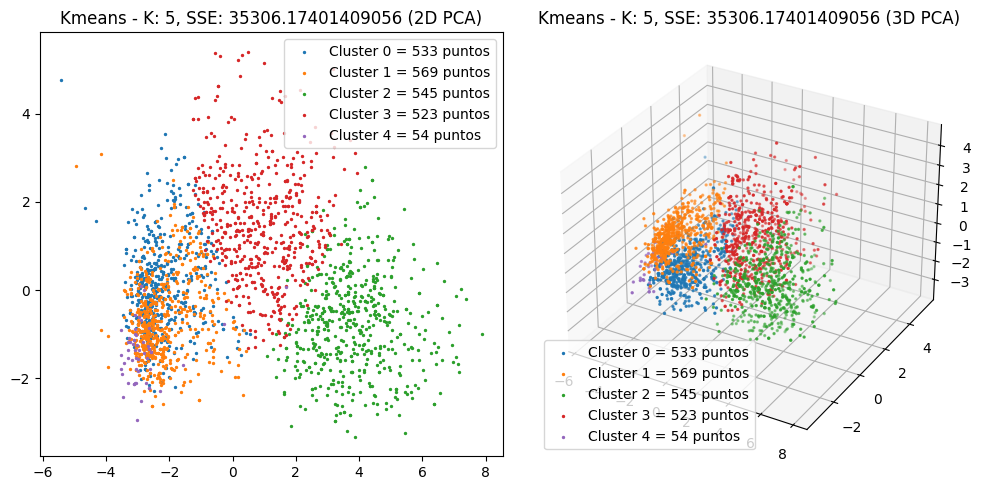

The best clustering for 5 clusters has an SSE value of 35306.17401409056


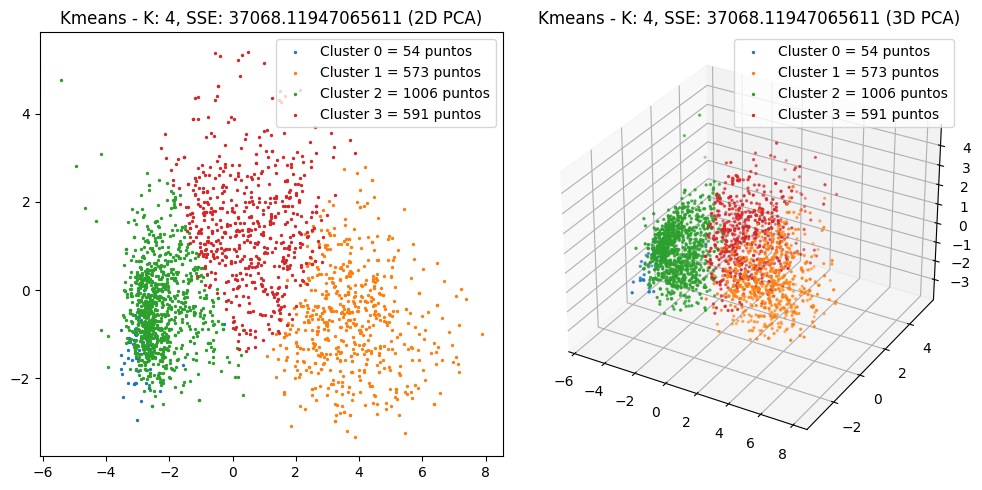

The best clustering for 4 clusters has an SSE value of 37068.11947065611


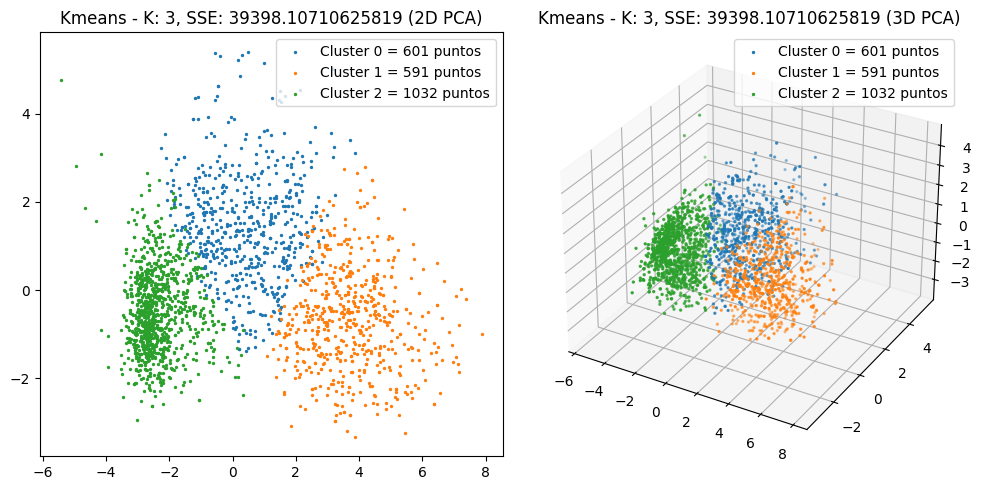

The best clustering for 3 clusters has an SSE value of 39398.10710625819


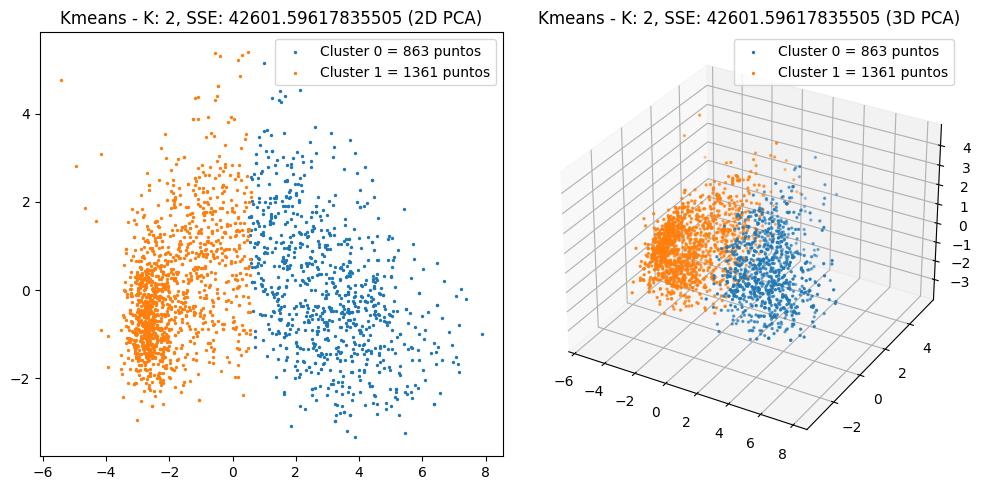

The best clustering for 2 clusters has an SSE value of 42601.59617835505


In [194]:
warnings.filterwarnings("ignore")

kmeans_config = [5,4,3,2]
num_iterations = 50

best_clusters_kmeans = [(np.inf,0),(np.inf,0),(np.inf,0),(np.inf,0)]

for i, config in enumerate(kmeans_config):
    k = config
    
    plt.figure(figsize=(10, 5))

    kmeans = KMeans(n_clusters=k)

    for j in range(num_iterations):
        clusters = kmeans.fit_predict(df_normalized)
        
        if kmeans.inertia_ < best_clusters_kmeans[i][0]:  
            unique_clusters, counts = np.unique(clusters, return_counts=True)
            best_clusters_kmeans[i] = (kmeans.inertia_, clusters)
    
    plt.subplot(1, 2, 1)
    for cluster_label in unique_clusters:
        cluster_mask = (best_clusters_kmeans[i][1] == cluster_label)
        plt.scatter(df_PCA2D[cluster_mask, 0], df_PCA2D[cluster_mask, 1], label=f'Cluster {cluster_label} = {counts[cluster_label]} puntos', s=2)
    plt.title(f'Kmeans - K: {k}, SSE: {best_clusters_kmeans[i][0]} (2D PCA)')
    plt.legend()
    
    # Visualizar los resultados en 3D
    ax = plt.subplot(1, 2, 2, projection='3d')
    for cluster_label in unique_clusters:
        cluster_mask = (best_clusters_kmeans[i][1] == cluster_label)
        ax.scatter(df_PCA3D[cluster_mask, 0], df_PCA3D[cluster_mask, 1], df_PCA3D[cluster_mask, 2], label=f'Cluster {cluster_label} = {counts[cluster_label]} puntos',s=2)
    plt.title(f'Kmeans - K: {k}, SSE: {best_clusters_kmeans[i][0]} (3D PCA)')
    ax.legend()

    plt.tight_layout()
    plt.show()

    print(f"The best clustering for {k} clusters has an SSE value of {best_clusters_kmeans[i][0]}")

## DBSCAN

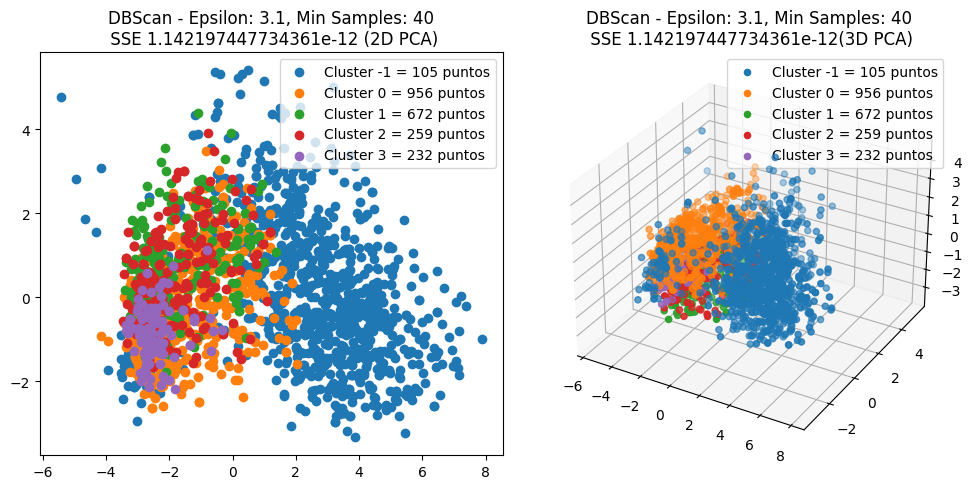

In [195]:
#Estos valores fueron obtenidos mediante ciclos de prueba y error
epsilons = [3.1]
min_samples_values = [40]

combinations_DBScan = list(itertools.product(epsilons, min_samples_values))
dbscan_configs = [{"epsilon": epsilon, "min_samples": min_samples} for epsilon, min_samples in combinations_DBScan]

sse_values = []


for i, config in enumerate(dbscan_configs):
    epsilon = config["epsilon"]
    min_samples = config["min_samples"]
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    clusters = dbscan.fit_predict(df_normalized)
    
    unique_clusters, counts = np.unique(clusters, return_counts=True)
    
    if len(set(clusters)) > 1:
        distances = pairwise_distances(df_normalized, metric='euclidean')
        sse = sum(np.min(distances[clusters != -1], axis=1)**2)
    else:
        sse = 0
    
    sse_values.append(sse)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    for cluster_label in unique_clusters:
        cluster_mask = (clusters == cluster_label)
        plt.scatter(df_PCA2D[cluster_mask, 0], df_PCA2D[cluster_mask, 1], label=f'Cluster {cluster_label} = {counts[cluster_label]} puntos')
    plt.title(f'DBScan - Epsilon: {epsilon}, Min Samples: {min_samples}\n SSE {sse} (2D PCA)')
    plt.legend()
    
    ax = plt.subplot(1, 2, 2, projection='3d')
    for cluster_label in unique_clusters:
        cluster_mask = (clusters == cluster_label)
        ax.scatter(df_PCA3D[cluster_mask, 0], df_PCA3D[cluster_mask, 1], df_PCA3D[cluster_mask, 2], label=f'Cluster {cluster_label} = {counts[cluster_label]} puntos')
    plt.title(f'DBScan - Epsilon: {epsilon}, Min Samples: {min_samples}\n SSE {sse}(3D PCA)')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    #Ploteado con asistencia de ChatGPT

best_cluster_dbscan = (sse, clusters)

## Hierarchical

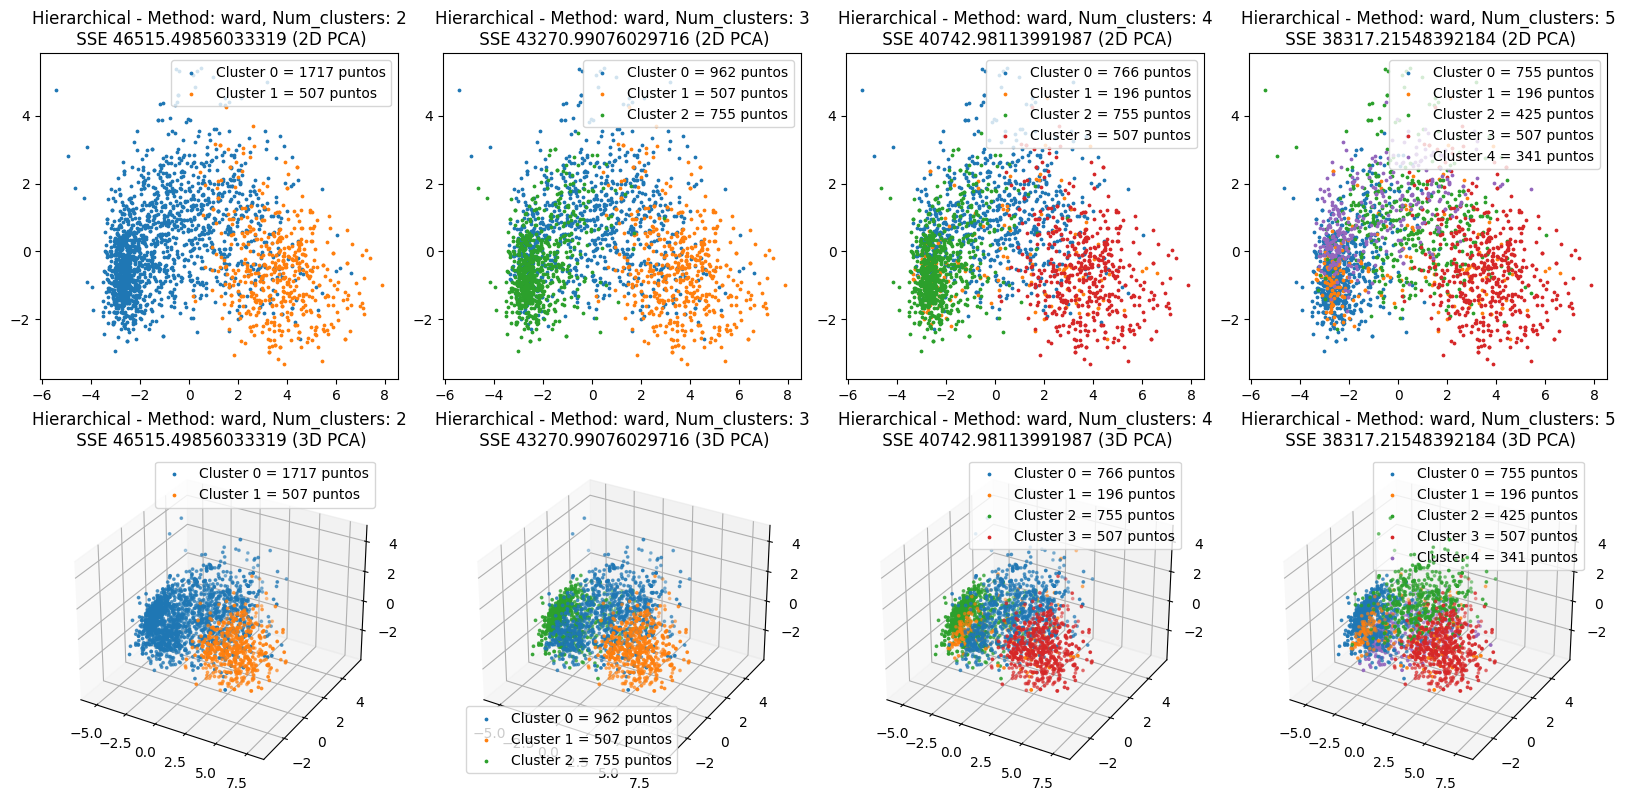

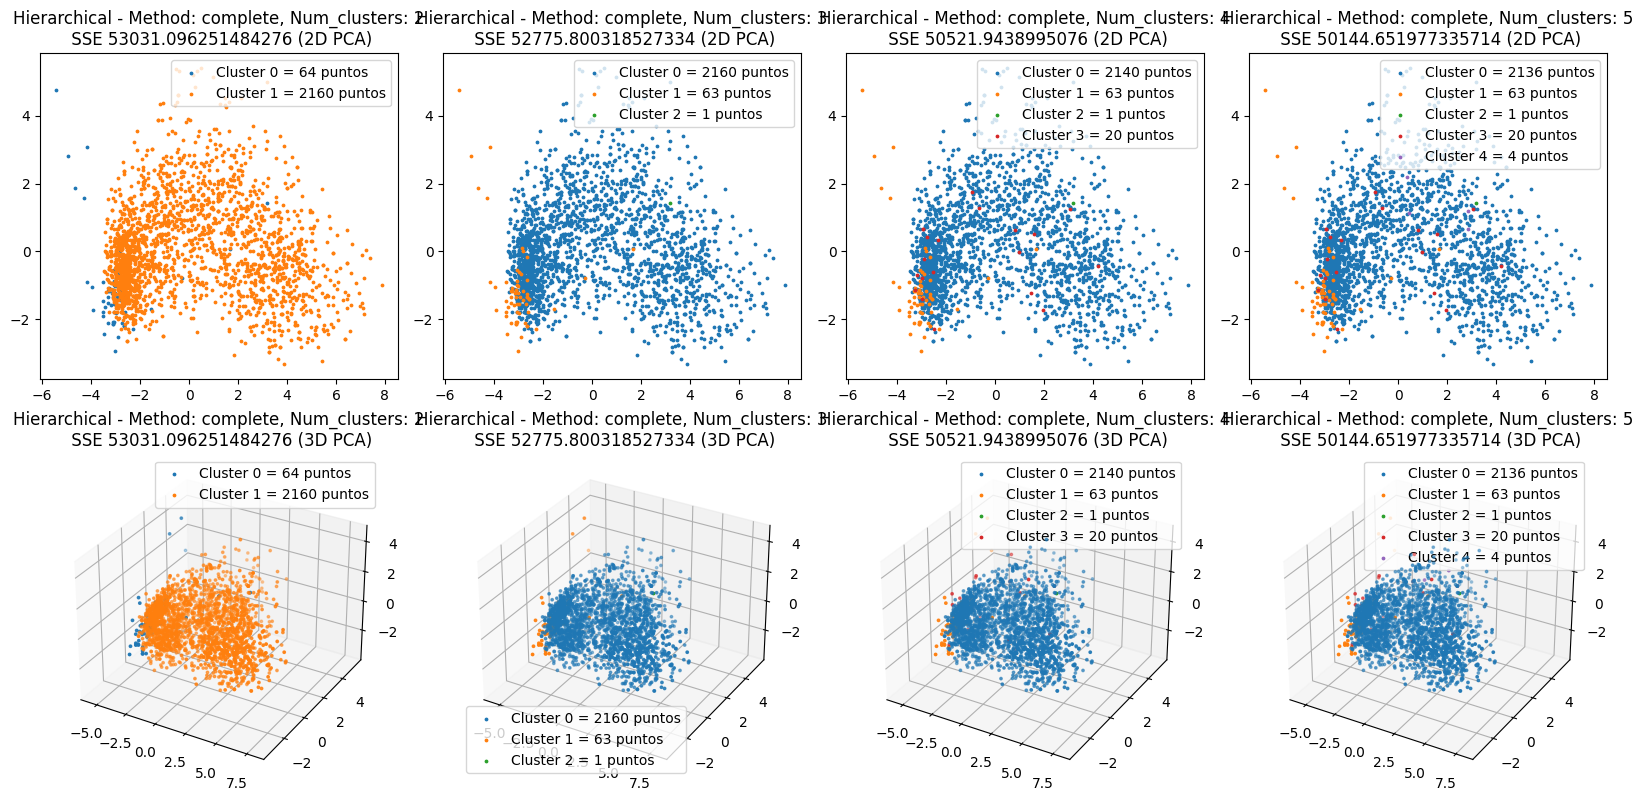

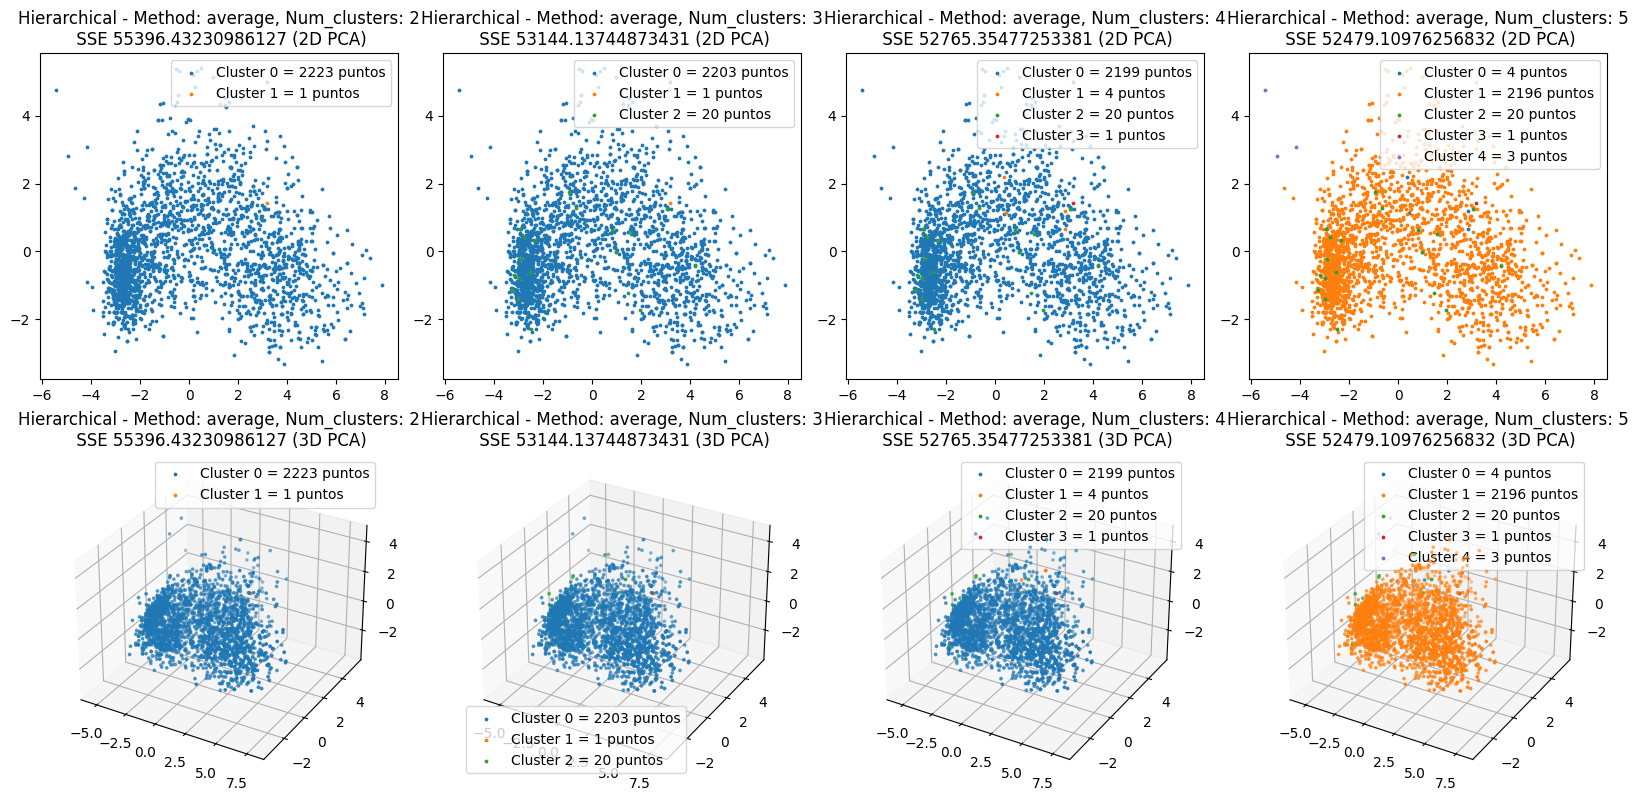

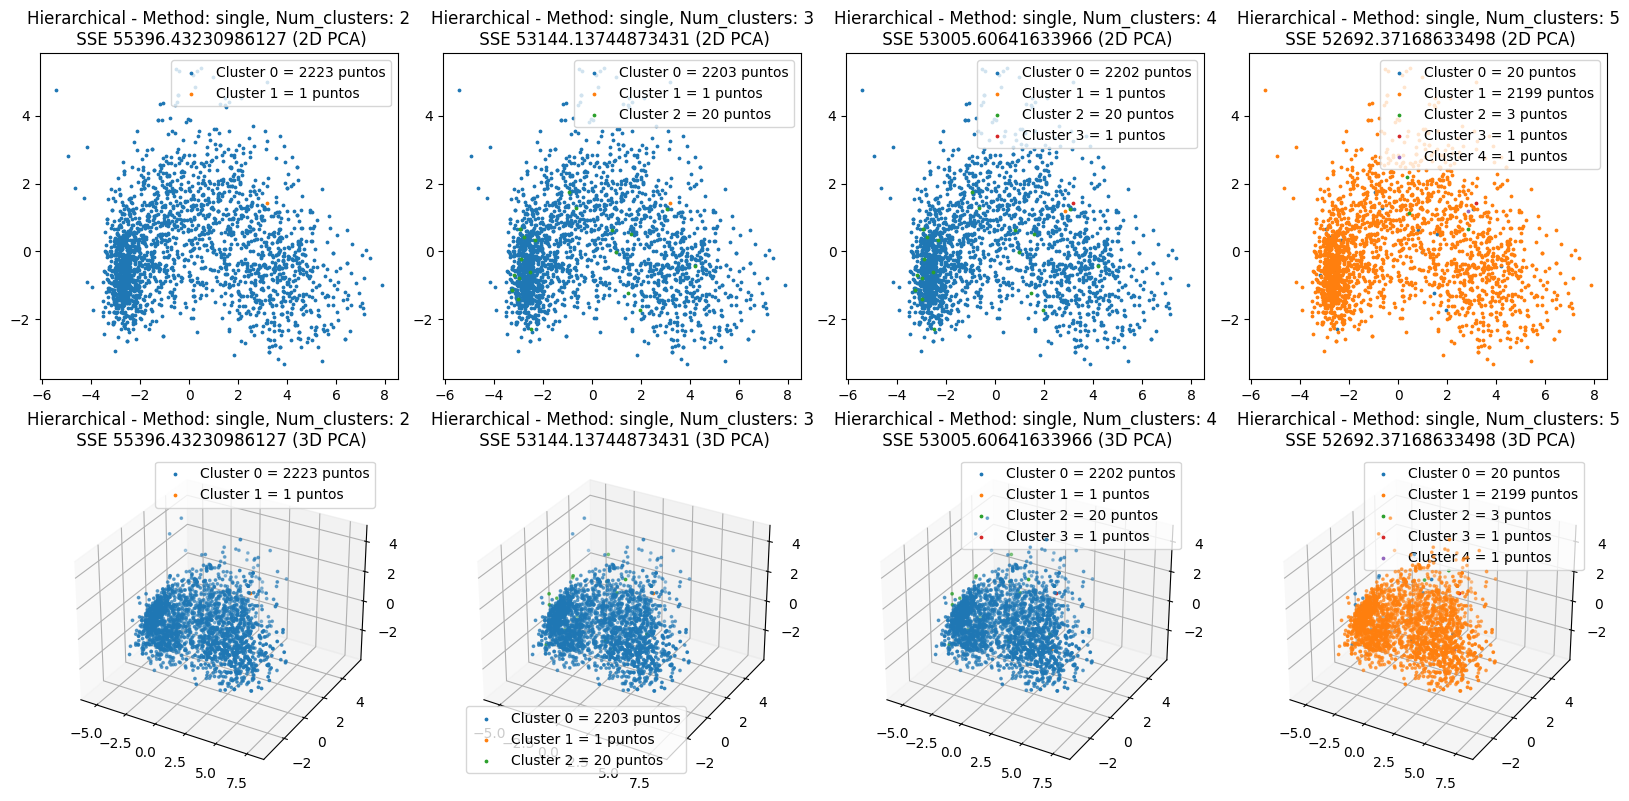

In [196]:
methods = ['ward', 'complete', 'average', 'single']
hierarchical_config = [2,3,4,5]

sse_hierarchical = {'ward':{2:0, 3:0, 4:0, 5:0},
                    'complete':{2:0, 3:0, 4:0, 5:0},
                    'average':{2:0, 3:0, 4:0, 5:0},
                    'single':{2:0, 3:0, 4:0, 5:0}}

for method in methods:
    plt.figure(figsize=(20, 8))

    for k in hierarchical_config:
        ac = AgglomerativeClustering(n_clusters = k, linkage=method)
        clusters = ac.fit_predict(df_normalized)

        centroids = []
        for label in np.unique(clusters):
            centroids.append(df_normalized.to_numpy()[clusters == label].mean(axis=0))

        sse = 0
        for i, point in enumerate(df_normalized.to_numpy()):
            cluster_label = clusters[i]
            centroid = centroids[cluster_label]
            sse += np.sum((point - centroid) ** 2)
            
        sse_hierarchical[method][k] = (sse, clusters)

        unique_clusters, counts = np.unique(clusters, return_counts=True)

        plt.subplot(2, 5, k)
        for cluster_label in unique_clusters:
            cluster_mask = (clusters == cluster_label)
            scatter = plt.scatter(df_PCA2D[cluster_mask,0], df_PCA2D[cluster_mask,1], label=f'Cluster {cluster_label} = {counts[cluster_label]} puntos', s=3)
        plt.title(f'Hierarchical - Method: {method}, Num_clusters: {k}\n SSE {sse} (2D PCA)')
        plt.legend()

        ax = plt.subplot(2, 5, 5 + k, projection='3d')
        for cluster_label in unique_clusters:
            cluster_mask = (clusters == cluster_label)
            scatter = ax.scatter(df_PCA3D[cluster_mask, 0], df_PCA3D[cluster_mask, 1], df_PCA3D[cluster_mask, 2], label=f'Cluster {cluster_label} = {counts[cluster_label]} puntos', s=3)
        plt.title(f'Hierarchical - Method: {method}, Num_clusters: {k}\n SSE {sse} (3D PCA)')
        ax.legend()

    plt.tight_layout()
    plt.show()

## Conclusión

Los únicos clústers que nos sirven de todos los candidatos, son los siguientes:
- De 4 clústers: DBSCAN
- De 3 clústers: K-means, Ward
- De 2 clústers: K-means, Ward

In [197]:
#Ward - 2
candidate_cluster_1 = sse_hierarchical['ward'][2][1]
candidate_sse_1 = sse_hierarchical['ward'][2][0]

#Kmeans - 2
candidate_cluster_2 = best_clusters_kmeans[3][1]
candidate_sse_2 = best_clusters_kmeans[3][0]

#Ward - 3
candidate_cluster_3 = sse_hierarchical['ward'][3][1]
candidate_sse_3 = sse_hierarchical['ward'][3][0]

#Kmeans - 3
candidate_cluster_4 = best_clusters_kmeans[2][1]
candidate_sse_4 = best_clusters_kmeans[2][0]

#DBSCAN - 4
candidate_cluster_5 = best_cluster_dbscan[1]
candidate_sse_5 = best_cluster_dbscan[0]

# Visualización de grupos

## Proyecciones

Revisemos cuales dimensiones mantienen la mayor cantidad de informacion, en el sentido de su varianza, para ver cuales son las mejores representaciones posibles.

In [198]:
def getBestProjection(A, C, targetdims=2):
    
    cluster_mean_list = []
    clusters_set = list(set(C))

    data = [[] for x in range(len(clusters_set))]

    for i, point in enumerate(A):
        cluster_index = clusters_set.index(C[i])
        data[cluster_index].append(point)

    for cluster_data in data:
        cluster_mean_list.append(np.average(cluster_data, axis=0))

    scores = []
    for att in range(A.shape[1]):
        score = 0
        for i in range(len(cluster_mean_list)):
            for j in range(i + 1, len(cluster_mean_list)):
                score += (cluster_mean_list[i][att] - cluster_mean_list[j][att])**2
        scores.append(score)

    max_values = heapq.nlargest(targetdims, scores)

    best_dims = []
    for element in max_values:
        best_dims.append(scores.index(element))
        
    return best_dims

In [199]:
np_data = df.to_numpy()
cols = df.columns

best_dims1 = getBestProjection(np_data, candidate_cluster_1, targetdims=3)
best_dims2 = getBestProjection(np_data, candidate_cluster_2, targetdims=3)
best_dims3 = getBestProjection(np_data, candidate_cluster_3, targetdims=3)
best_dims4 = getBestProjection(np_data, candidate_cluster_4, targetdims=3)
best_dims5 = getBestProjection(np_data, candidate_cluster_5, targetdims=3)

In [200]:
print(best_dims1)
print(best_dims2)
print(best_dims3)
print(best_dims4)
print(best_dims5)

[0, 24, 2]
[0, 24, 2]
[0, 24, 2]
[0, 24, 2]
[0, 24, 2]


Como podemos ver, las mejores dimensiones para todos los casos son la primera y la ultima, Income y Total_Spent. La siguiente mejor es la tercera, Mnt_wines.

Grafiquemos todos los clusters para encontrar alguna relacion

## Graficas - Mejores Dimensiones

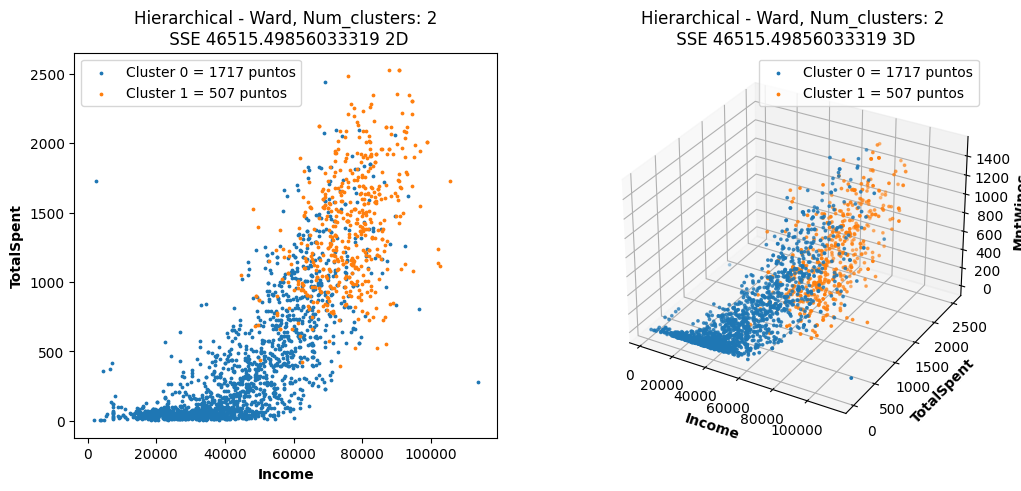

In [201]:
unique_clusters, counts = np.unique(candidate_cluster_1, return_counts=True)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for cluster_label in unique_clusters:
    cluster_mask = (candidate_cluster_1 == cluster_label)
    scatter = plt.scatter(np_data[cluster_mask, best_dims1[0]], np_data[cluster_mask,best_dims1[1]], label=f'Cluster {cluster_label} = {counts[cluster_label]} puntos', s=3)
plt.title(f'Hierarchical - Ward, Num_clusters: 2\n SSE {candidate_sse_1} 2D')
plt.xlabel(f'{cols[best_dims1[0]]}', fontweight ='bold')
plt.ylabel(f'{cols[best_dims1[1]]}', fontweight ='bold')
plt.legend()

ax = plt.subplot(1, 2, 2, projection='3d')
for cluster_label in unique_clusters:
    cluster_mask = (candidate_cluster_1 == cluster_label)
    scatter = ax.scatter(np_data[cluster_mask, best_dims1[0]], np_data[cluster_mask,best_dims1[1]], np_data[cluster_mask, best_dims1[2]], label=f'Cluster {cluster_label} = {counts[cluster_label]} puntos', s=3)
plt.title(f'Hierarchical - Ward, Num_clusters: 2\n SSE {candidate_sse_1} 3D')
ax.set_xlabel(f'{cols[best_dims1[0]]}', fontweight ='bold')
ax.set_ylabel(f'{cols[best_dims1[1]]}', fontweight ='bold')
ax.set_zlabel(f'{cols[best_dims1[2]]}', fontweight ='bold')
ax.legend()
plt.show()

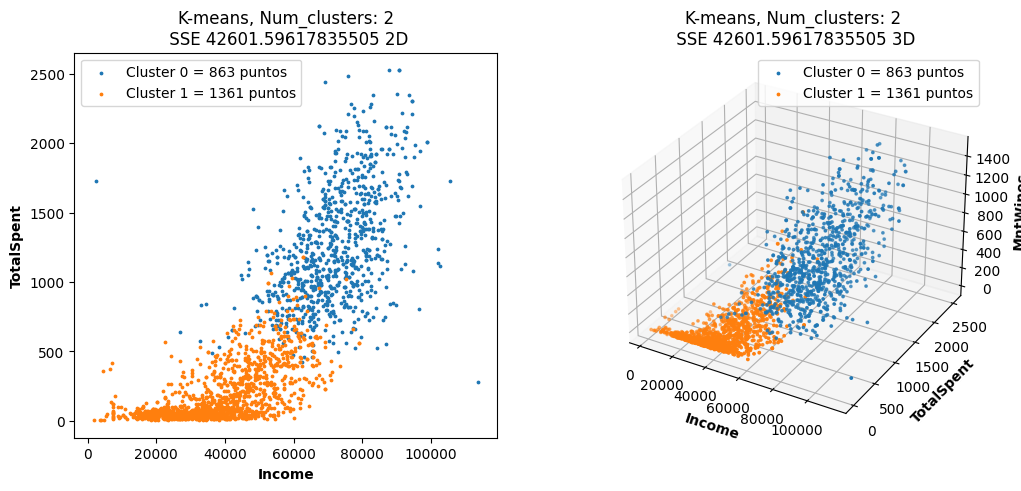

In [202]:
unique_clusters, counts = np.unique(candidate_cluster_2, return_counts=True)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for cluster_label in unique_clusters:
    cluster_mask = (candidate_cluster_2 == cluster_label)
    scatter = plt.scatter(np_data[cluster_mask, best_dims2[0]], np_data[cluster_mask,best_dims2[1]], label=f'Cluster {cluster_label} = {counts[cluster_label]} puntos', s=3)
plt.title(f'K-means, Num_clusters: 2\n SSE {candidate_sse_2} 2D')
plt.xlabel(f'{cols[best_dims2[0]]}', fontweight ='bold')
plt.ylabel(f'{cols[best_dims2[1]]}', fontweight ='bold')
plt.legend()

ax = plt.subplot(1, 2, 2, projection='3d')
for cluster_label in unique_clusters:
    cluster_mask = (candidate_cluster_2 == cluster_label)
    scatter = ax.scatter(np_data[cluster_mask, best_dims2[0]], np_data[cluster_mask,best_dims2[1]], np_data[cluster_mask, best_dims2[2]], label=f'Cluster {cluster_label} = {counts[cluster_label]} puntos', s=3)
plt.title(f'K-means, Num_clusters: 2\n SSE {candidate_sse_2} 3D')
ax.set_xlabel(f'{cols[best_dims2[0]]}', fontweight ='bold')
ax.set_ylabel(f'{cols[best_dims2[1]]}', fontweight ='bold')
ax.set_zlabel(f'{cols[best_dims2[2]]}', fontweight ='bold')
ax.legend()
plt.show()

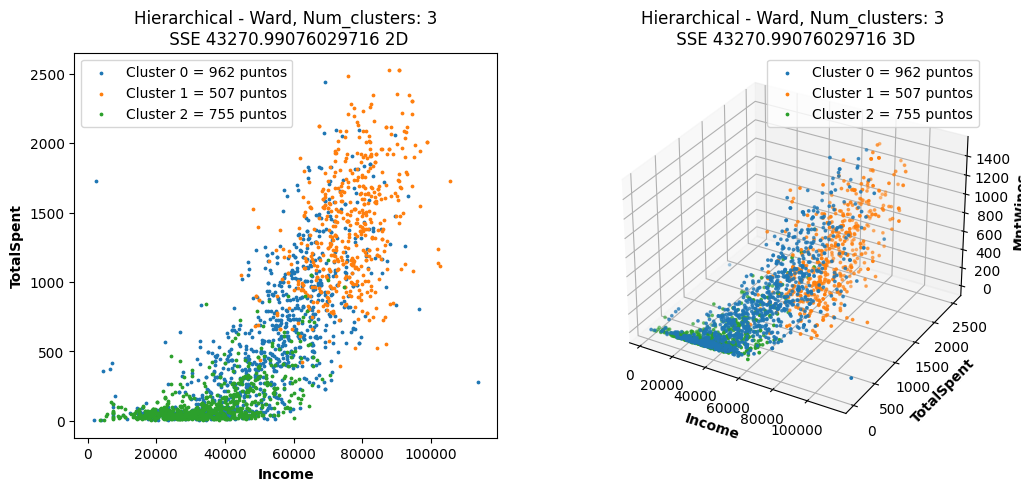

In [203]:
unique_clusters, counts = np.unique(candidate_cluster_3, return_counts=True)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for cluster_label in unique_clusters:
    cluster_mask = (candidate_cluster_3 == cluster_label)
    scatter = plt.scatter(np_data[cluster_mask, best_dims3[0]], np_data[cluster_mask,best_dims3[1]], label=f'Cluster {cluster_label} = {counts[cluster_label]} puntos', s=3)
plt.title(f'Hierarchical - Ward, Num_clusters: 3\n SSE {candidate_sse_3} 2D')
plt.xlabel(f'{cols[best_dims3[0]]}', fontweight ='bold')
plt.ylabel(f'{cols[best_dims3[1]]}', fontweight ='bold')
plt.legend()

ax = plt.subplot(1, 2, 2, projection='3d')
for cluster_label in unique_clusters:
    cluster_mask = (candidate_cluster_3 == cluster_label)
    scatter = ax.scatter(np_data[cluster_mask, best_dims3[0]], np_data[cluster_mask,best_dims3[1]], np_data[cluster_mask, best_dims3[2]], label=f'Cluster {cluster_label} = {counts[cluster_label]} puntos', s=3)
plt.title(f'Hierarchical - Ward, Num_clusters: 3\n SSE {candidate_sse_3} 3D')
ax.set_xlabel(f'{cols[best_dims3[0]]}', fontweight ='bold')
ax.set_ylabel(f'{cols[best_dims3[1]]}', fontweight ='bold')
ax.set_zlabel(f'{cols[best_dims3[2]]}', fontweight ='bold')
ax.legend()
plt.show()

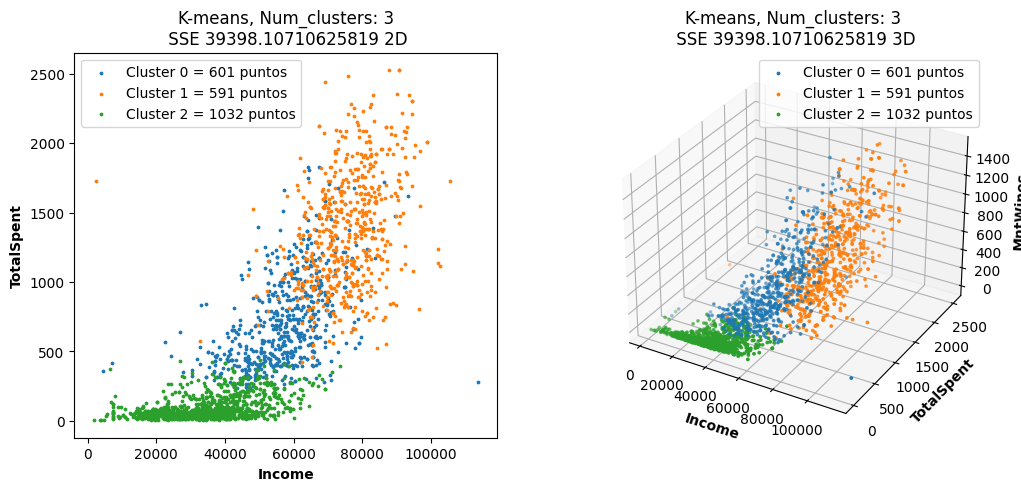

In [204]:
unique_clusters, counts = np.unique(candidate_cluster_4, return_counts=True)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for cluster_label in unique_clusters:
    cluster_mask = (candidate_cluster_4 == cluster_label)
    scatter = plt.scatter(np_data[cluster_mask, best_dims4[0]], np_data[cluster_mask,best_dims4[1]], label=f'Cluster {cluster_label} = {counts[cluster_label]} puntos', s=3)
plt.title(f'K-means, Num_clusters: 3\n SSE {candidate_sse_4} 2D')
plt.xlabel(f'{cols[best_dims4[0]]}', fontweight ='bold')
plt.ylabel(f'{cols[best_dims4[1]]}', fontweight ='bold')
plt.legend()

ax = plt.subplot(1, 2, 2, projection='3d')
for cluster_label in unique_clusters:
    cluster_mask = (candidate_cluster_4 == cluster_label)
    scatter = ax.scatter(np_data[cluster_mask, best_dims4[0]], np_data[cluster_mask,best_dims4[1]], np_data[cluster_mask, best_dims4[2]], label=f'Cluster {cluster_label} = {counts[cluster_label]} puntos', s=3)
plt.title(f'K-means, Num_clusters: 3\n SSE {candidate_sse_4} 3D')
ax.set_xlabel(f'{cols[best_dims4[0]]}', fontweight ='bold')
ax.set_ylabel(f'{cols[best_dims4[1]]}', fontweight ='bold')
ax.set_zlabel(f'{cols[best_dims4[2]]}', fontweight ='bold')
ax.legend()
plt.show()

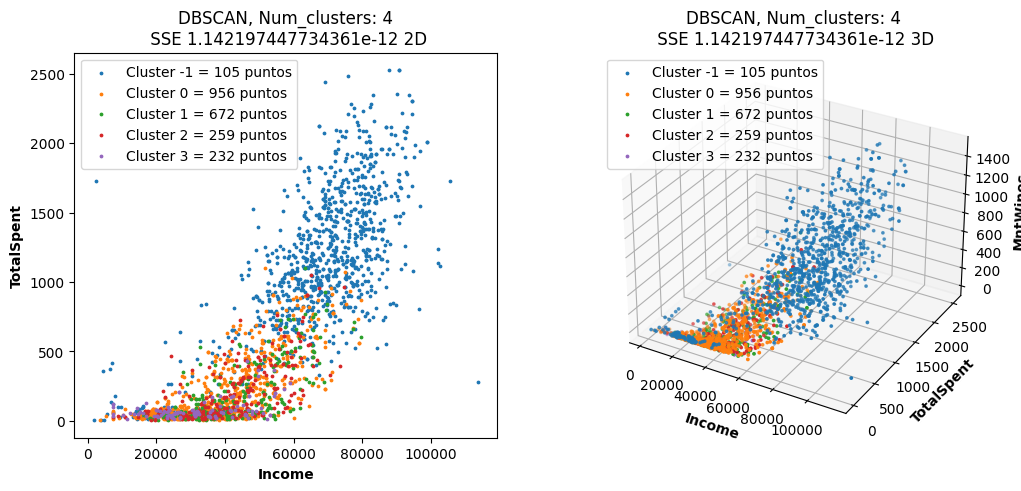

In [210]:
unique_clusters, counts = np.unique(candidate_cluster_5, return_counts=True)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for cluster_label in unique_clusters:
    cluster_mask = (candidate_cluster_5 == cluster_label)
    scatter = plt.scatter(np_data[cluster_mask, best_dims5[0]], np_data[cluster_mask,best_dims5[1]], label=f'Cluster {cluster_label} = {counts[cluster_label]} puntos', s=3)
plt.title(f'DBSCAN, Num_clusters: 4\n SSE {candidate_sse_5} 2D')
plt.xlabel(f'{cols[best_dims5[0]]}', fontweight ='bold')
plt.ylabel(f'{cols[best_dims5[1]]}', fontweight ='bold')
plt.legend()

ax = plt.subplot(1, 2, 2, projection='3d')
for cluster_label in unique_clusters:
    cluster_mask = (candidate_cluster_5 == cluster_label)
    scatter = ax.scatter(np_data[cluster_mask, best_dims5[0]], np_data[cluster_mask,best_dims5[1]], np_data[cluster_mask, best_dims5[2]], label=f'Cluster {cluster_label} = {counts[cluster_label]} puntos', s=3)
plt.title(f'DBSCAN, Num_clusters: 4\n SSE {candidate_sse_5} 3D')
ax.set_xlabel(f'{cols[best_dims5[0]]}', fontweight ='bold')
ax.set_ylabel(f'{cols[best_dims5[1]]}', fontweight ='bold')
ax.set_zlabel(f'{cols[best_dims5[2]]}', fontweight ='bold')
ax.legend()
plt.show()

De estas graficas, podemos ver que la única campaña posible que podemos extraer de ella se podría relacionar a la cantidad de dinero gastado (Ex. Para los rangos entre 0 y 500, 500 y 1000, y 1000+), o relacionado a los ingresos del cliente, pero dado que este ultima no tiene mucho sentido a nivel de campaña, exploraremos otras opciones.

## Limpiar la cantidad de candidatos

Con base a las anteriores gráficas, podemos ver que los clusterings varían relativamente poco cuando tienen el mismo número de clusters. Se puede notar una mejoría a nivel visual sin embargo que concuerda con el SSE que tienen los clusterings, que entre menor es, mejor agrupaciones representa. Debido a esto, nos quedaremos tan solo con el clustering que tenga menor SSE para cada numero de k.

In [211]:
print(f'K = 2. Cluster 1 has an SSE of {candidate_sse_1}, cluster 2 has an SSE of {candidate_sse_2}')
print(f'K = 3. Cluster 1 has an SSE of {candidate_sse_3}, cluster 2 has an SSE of {candidate_sse_4}')
print('K = 4. El unico clustering no parece ser ideal. Lo dropearemos.')

K = 2. Cluster 1 has an SSE of 42601.59617835505, cluster 2 has an SSE of 39398.10710625819
K = 3. Cluster 1 has an SSE of 43270.99076029716, cluster 2 has an SSE of 39398.10710625819
K = 4. El unico clustering no parece ser ideal. Lo dropearemos.


In [212]:
#Kmeans - 2
candidate_cluster_1 = best_clusters_kmeans[3][1]
candidate_sse_1 = best_clusters_kmeans[3][0]

#Kmeans - 3
candidate_cluster_2 = best_clusters_kmeans[2][1]
candidate_sse_2 = best_clusters_kmeans[2][0]

## Gráficas - Exploración de dimensiones

A fin de poder abordar a los diferentes grupos en base a características más comunes, postulamos las siguientes dimensiones:
- Edad
- Soltero/En pareja
- Hijos
- Numero de compras por catalogo/web/tienda
- Ingresos

Además de esto, compararemos ahora las mejores dimensiones con cada producto, para intentar definir alguna mejor campaña

In [216]:
interesting_cols = [0,9,10,11,14,15,22]
prod_cols = [2,3,4,5,6,7]
candidates = [candidate_cluster_1,candidate_cluster_2]

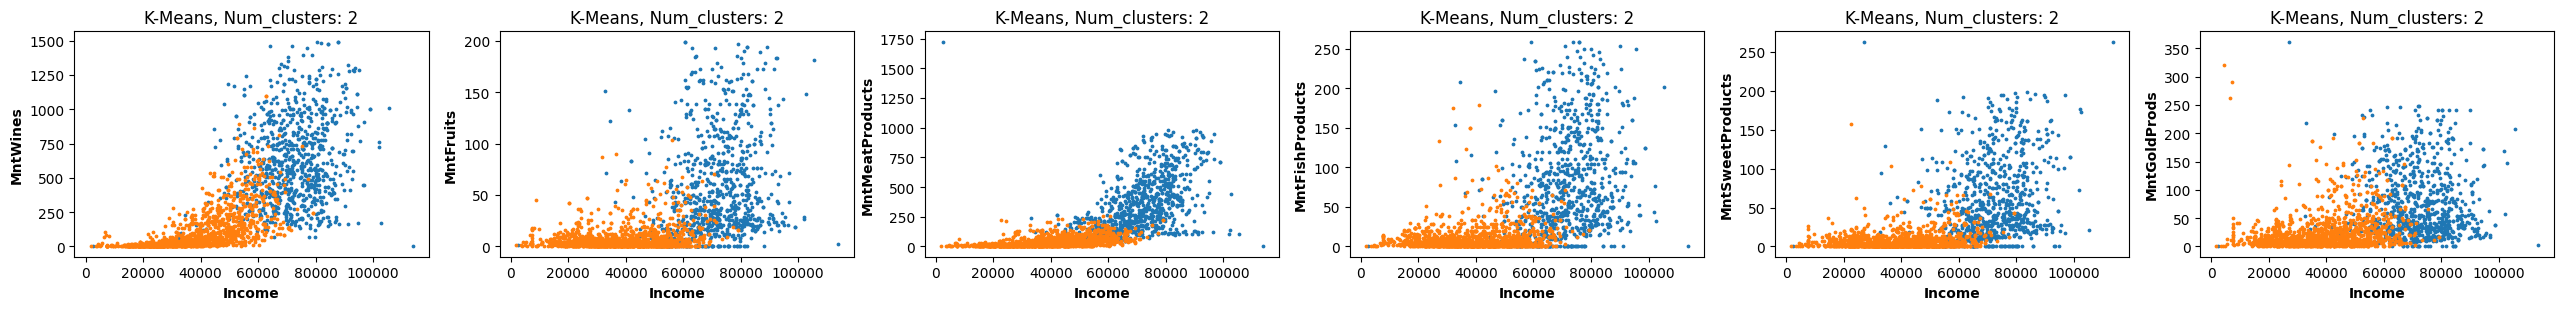

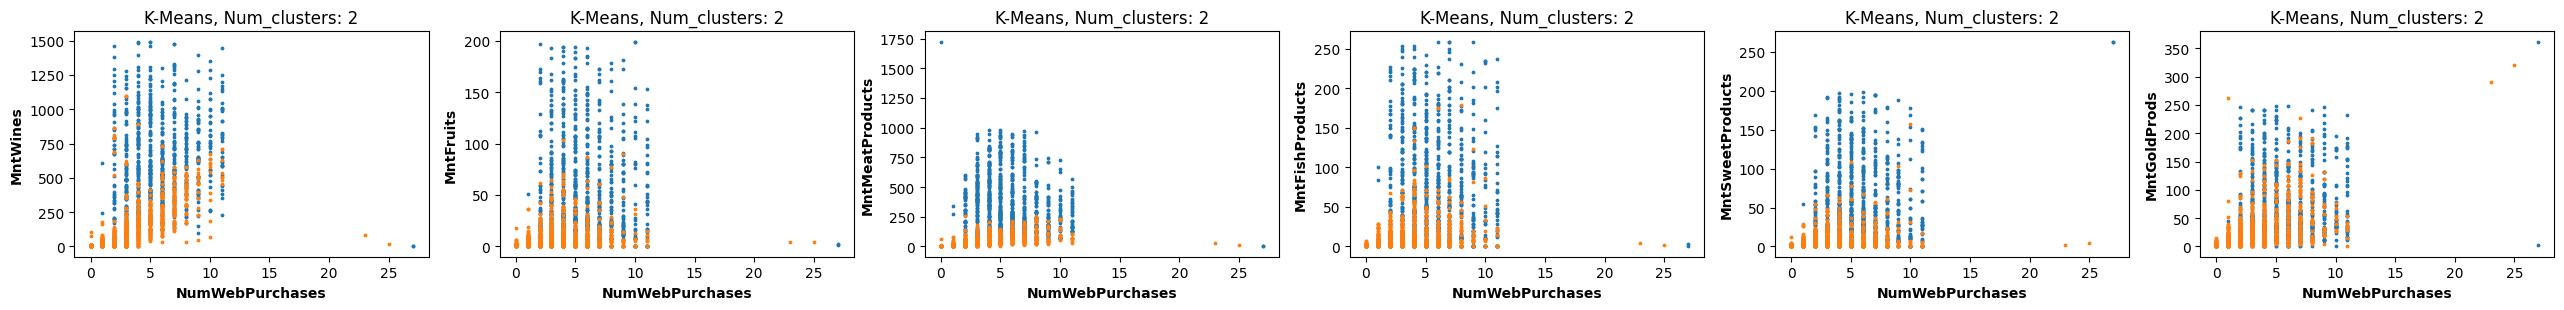

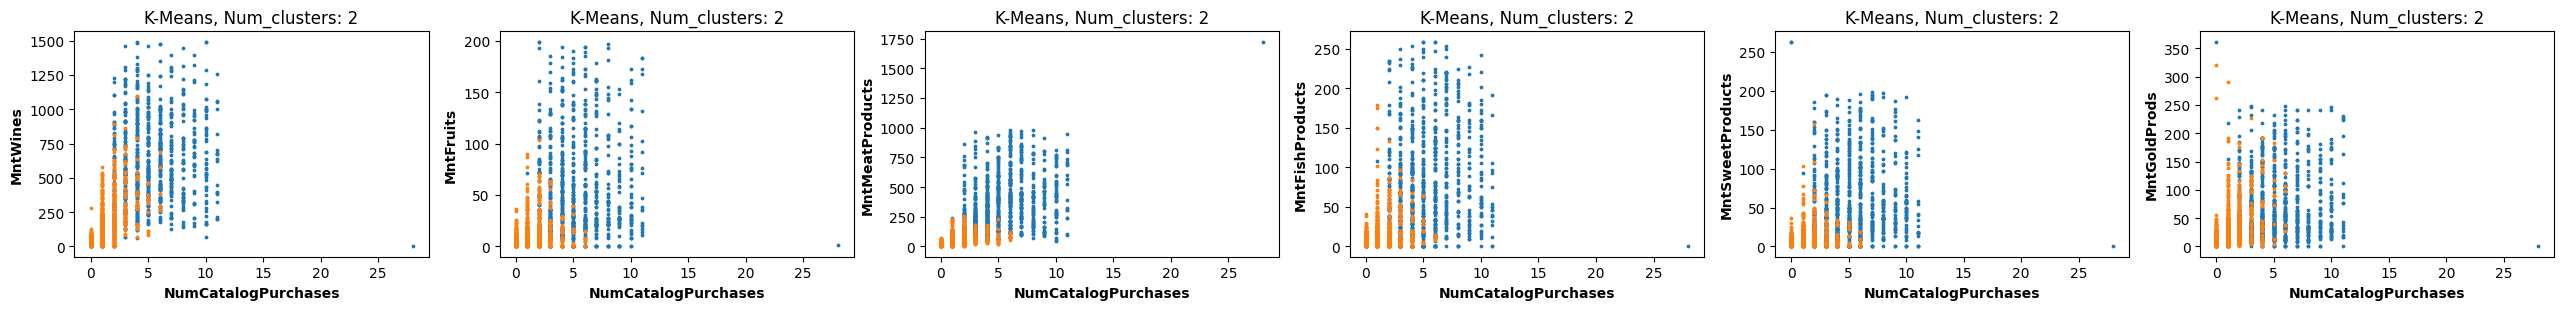

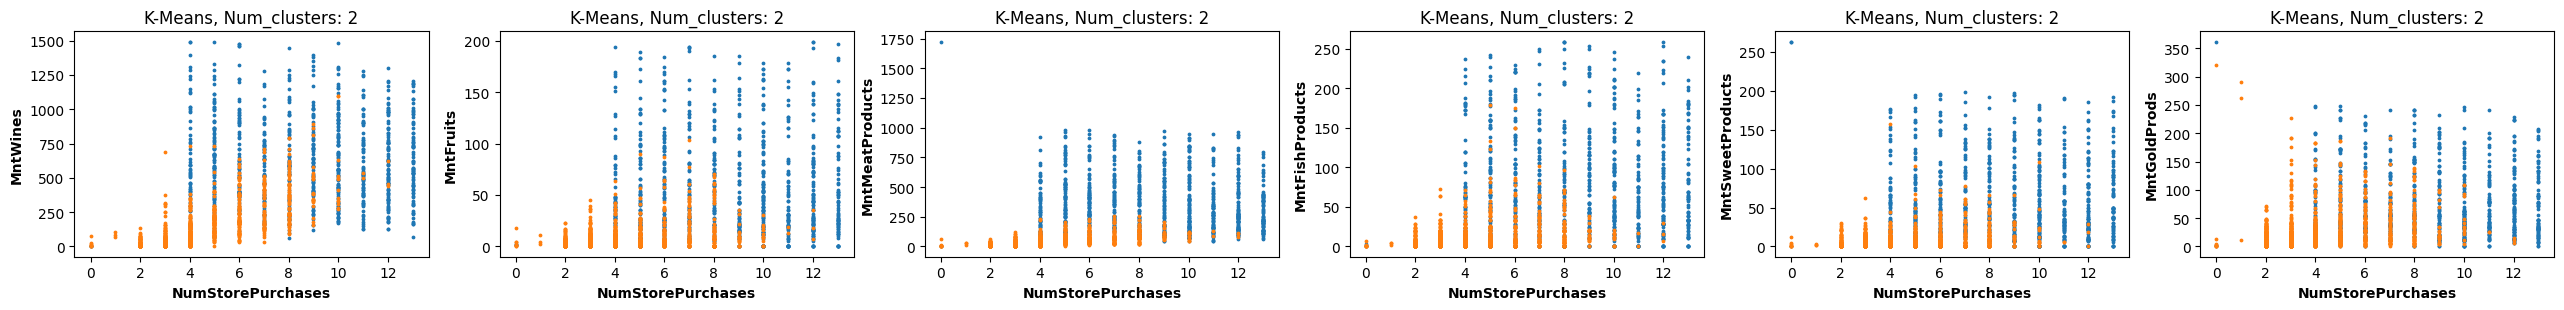

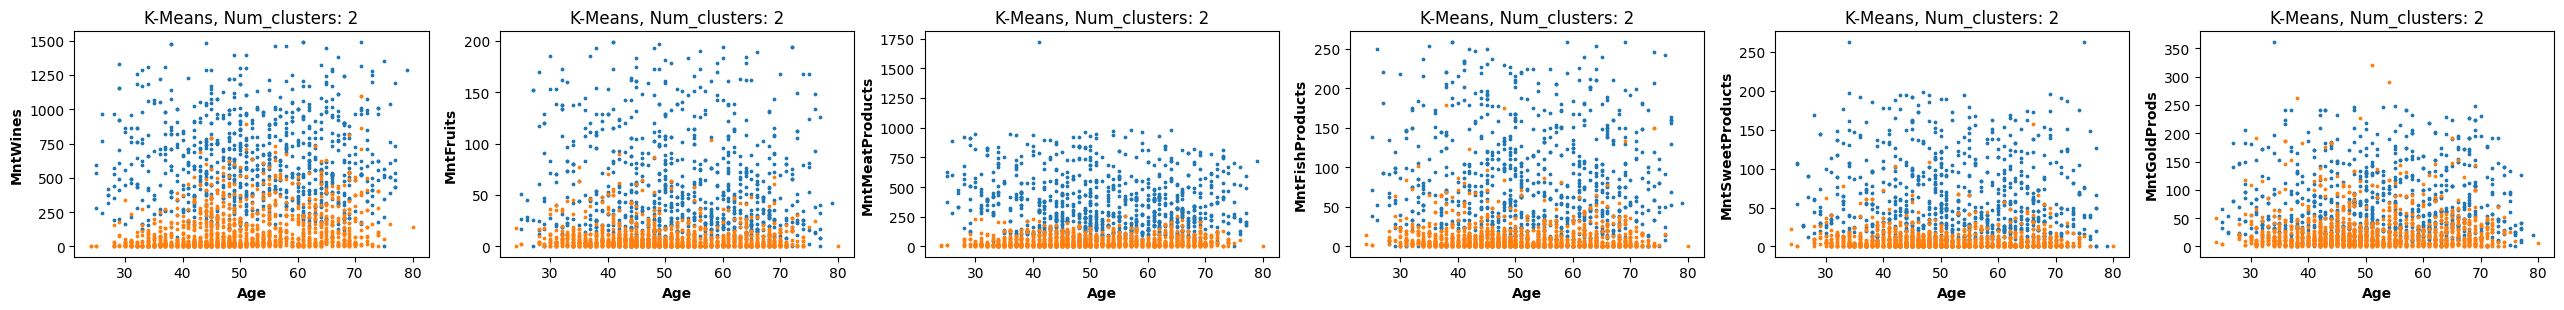

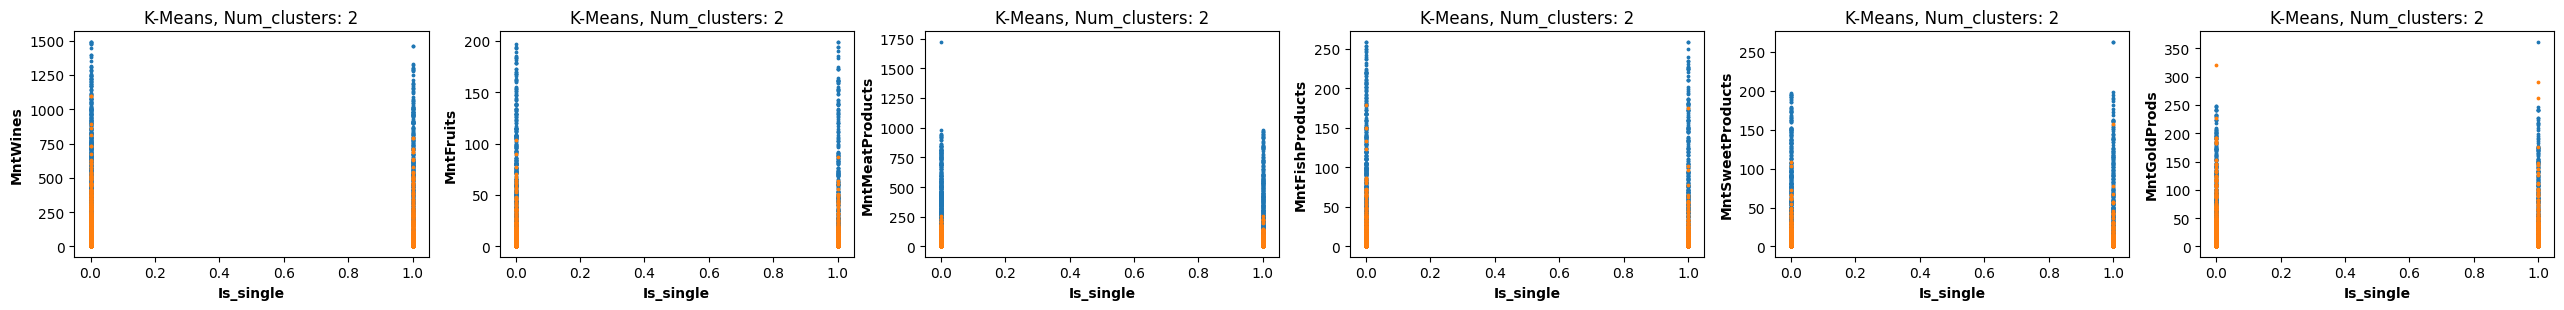

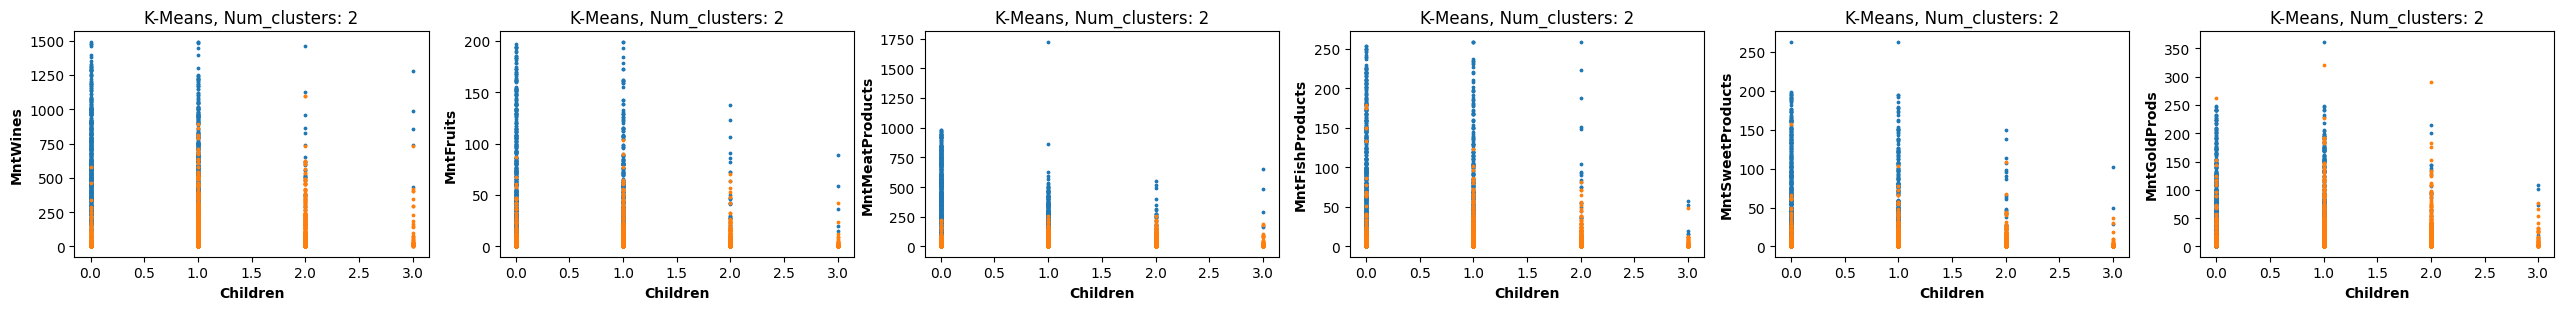

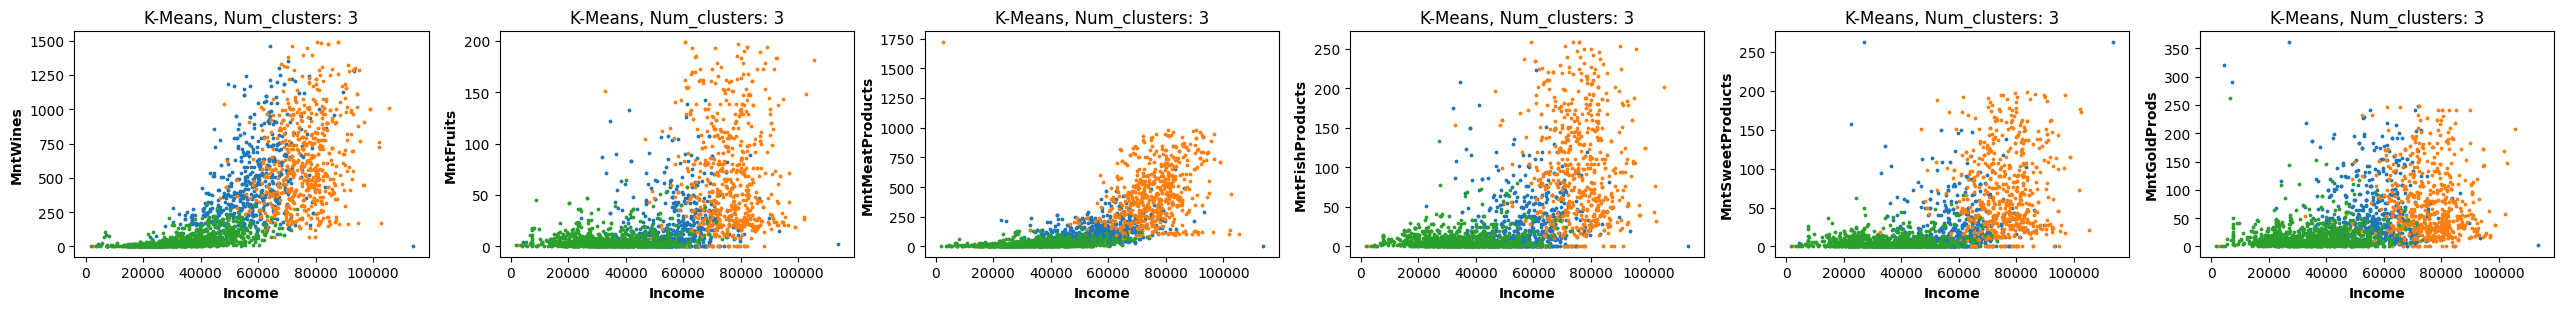

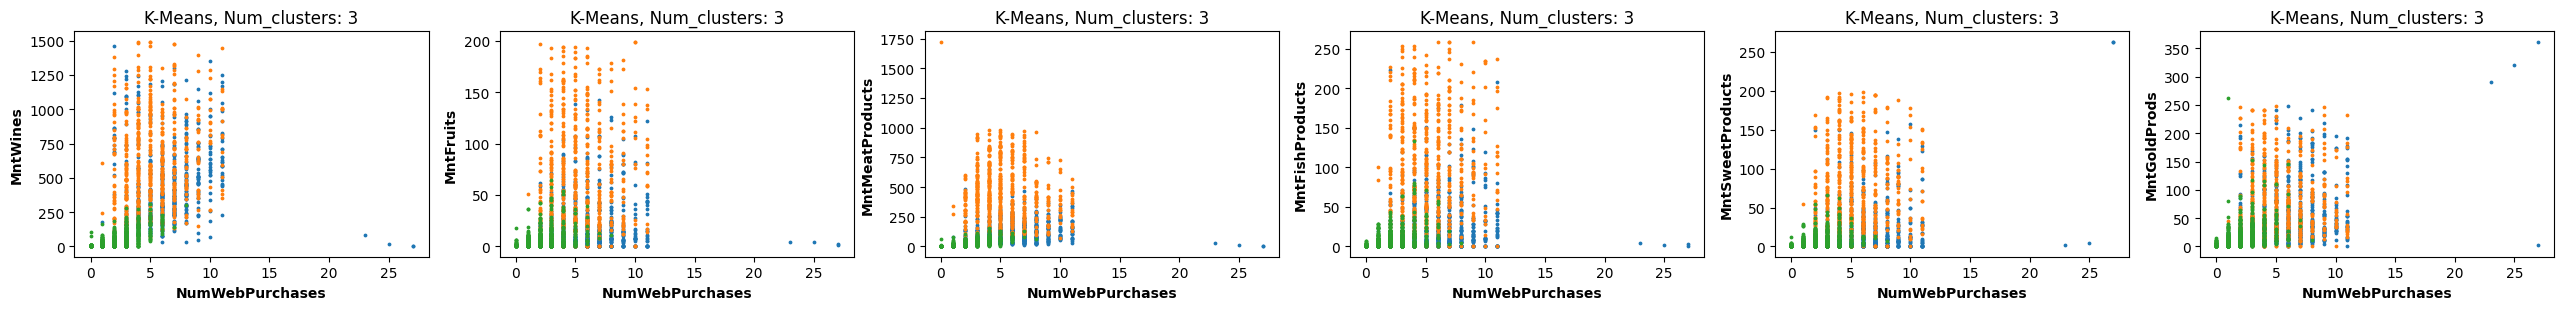

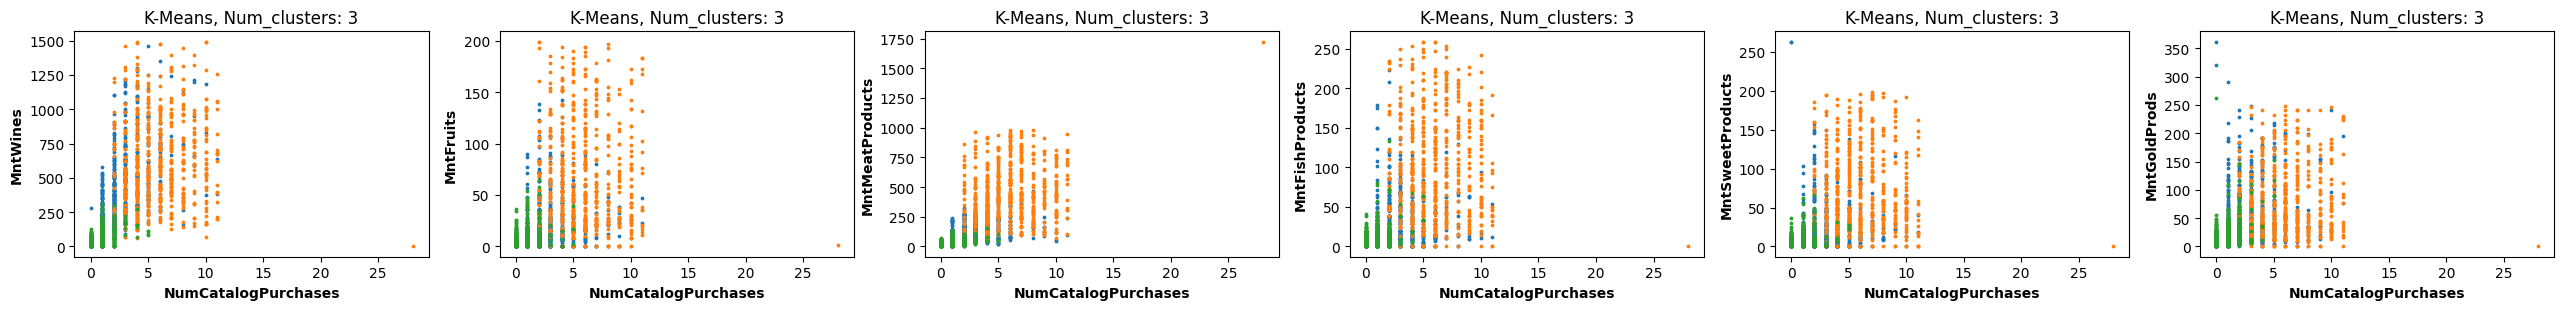

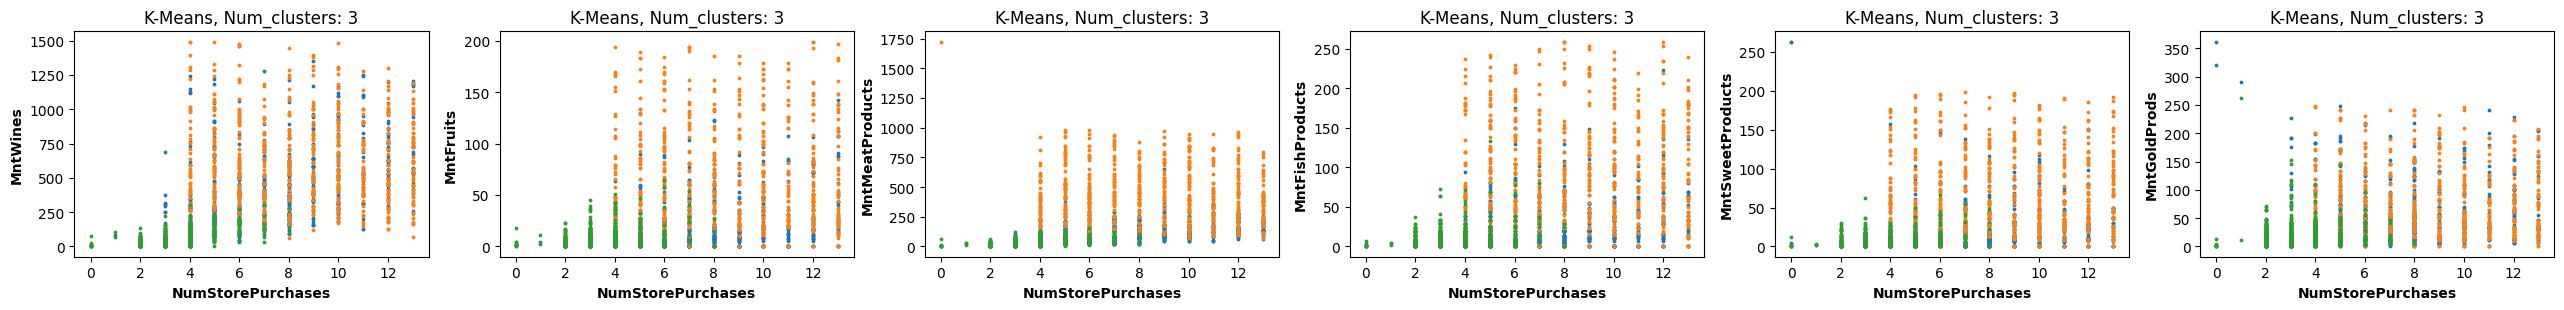

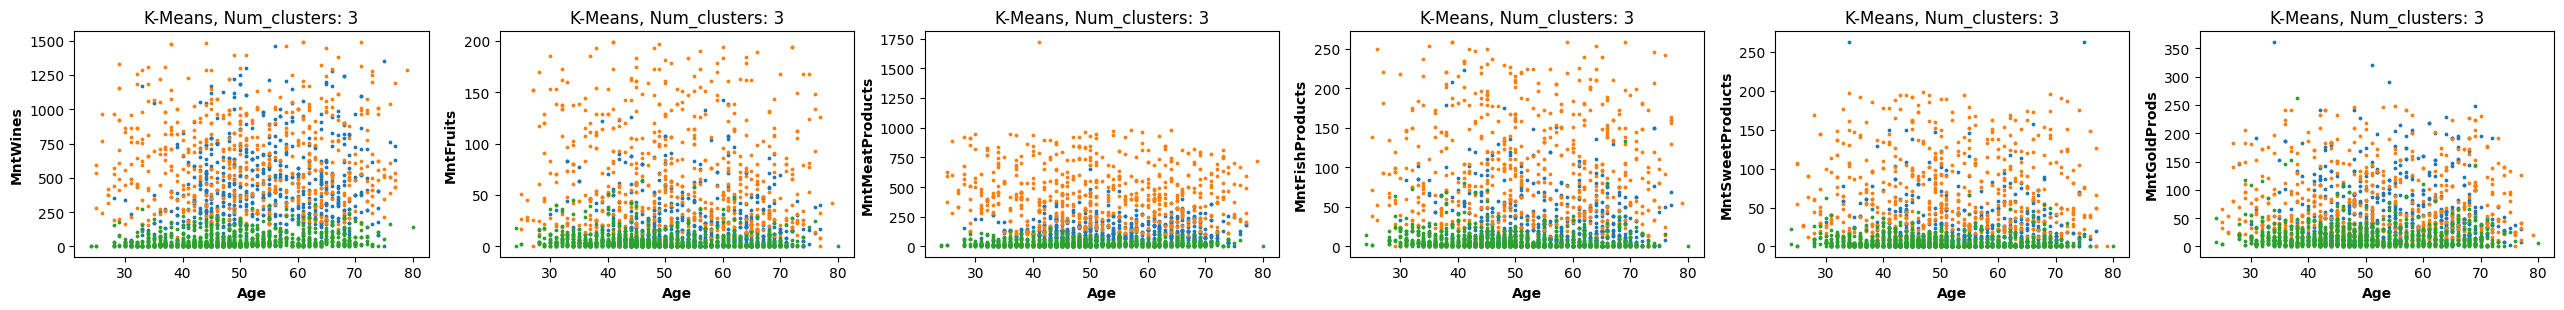

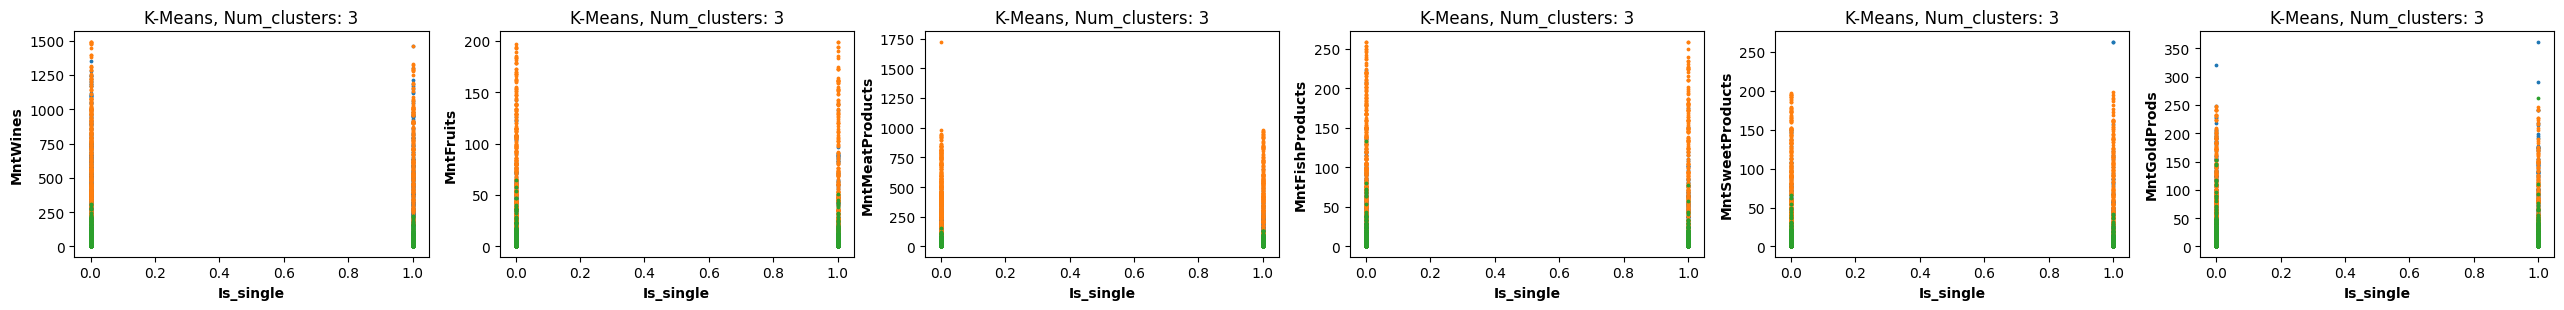

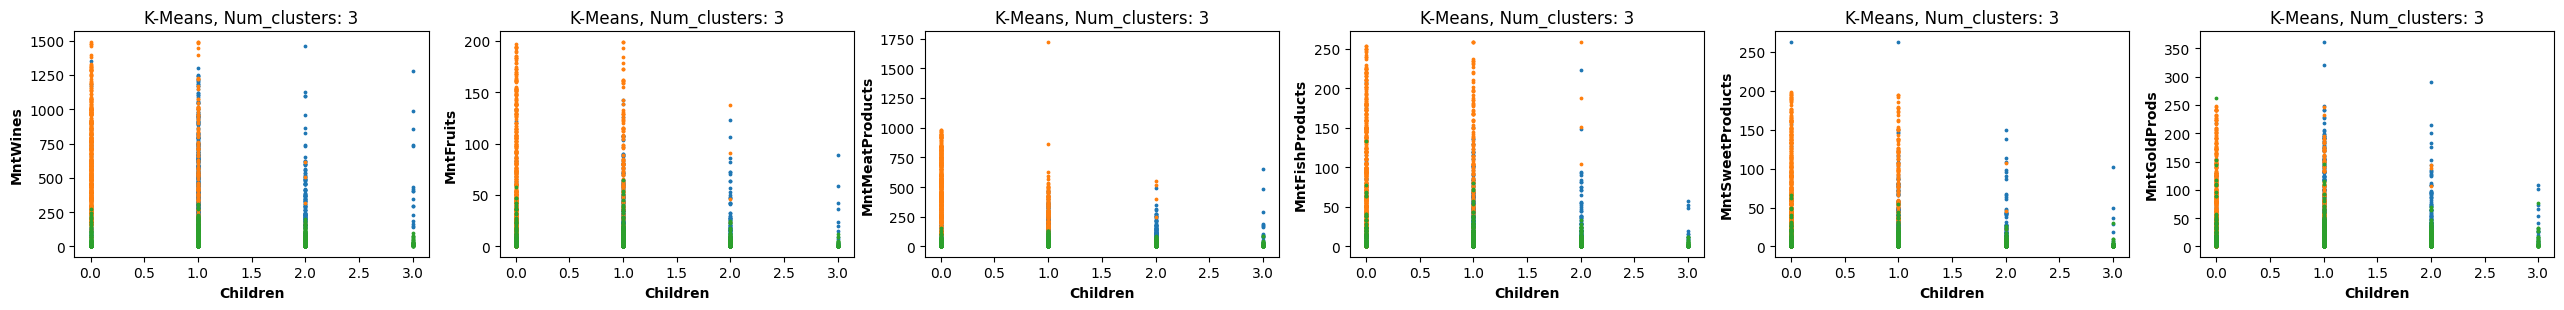

In [217]:
for l, candidate in enumerate(candidates):
    for i, int_col in enumerate(interesting_cols):
        plt.figure(figsize=(32, 24))

        for j, prod_col in enumerate(prod_cols):
            unique_clusters, counts = np.unique(candidate, return_counts=True)

            plt.subplot(len(interesting_cols), len(prod_cols), i * len(prod_cols) + j + 1)
            for cluster_label in unique_clusters:
                cluster_mask = (candidate == cluster_label)
                scatter = plt.scatter(np_data[cluster_mask, int_col], np_data[cluster_mask, prod_col], label=f'Cluster {cluster_label} = {counts[cluster_label]} puntos', s=3)
            plt.title(f'K-Means, Num_clusters: {len(unique_clusters)}')
            plt.xlabel(f'{cols[int_col]}', fontweight ='bold')
            plt.ylabel(f'{cols[prod_col]}', fontweight ='bold')
        
        plt.show()

# Conclusiones

Del análisis visual de las gráficas, podemos concluir que la campaña ideal es:
- 